#Final Project Report

GROUP MEMBERS:
*   Arshdeep Bamrah
*   Luke Fregonese
*   Lana Hassoune
*   Stefano Scaini

FINAL PROJECT GOOGLE COLAB LINK:

https://colab.research.google.com/drive/1N5r2z--KioQuZ3uOdPl8Fd5wwAMcI5f9?usp=sharing

##Project Description

This document details the step-by-step walkthrough of the Deep Learning Final project produced by Group 10. 

For our project we developed a neural network that can intake a variety of photos and generate appropriate captions to describe them. This design case is commonly referred to as image-captioning, and uses natural language processing to communicate visual inputs, in this case images. In order to accomplish this, we divided the task into two main components: the first part took in the images and analyzed their essential features and characteristics, while the second performed the language modelling.

For the image processing, we used a pre-trained Inception model as our convolutional neural network. Using this, we extracted image features and passed them into the RNN. For the language processing, we combined these image features with soft attention to generate sentences that described the image. From there, our model outputs the most appropriate caption with its corresponding image.

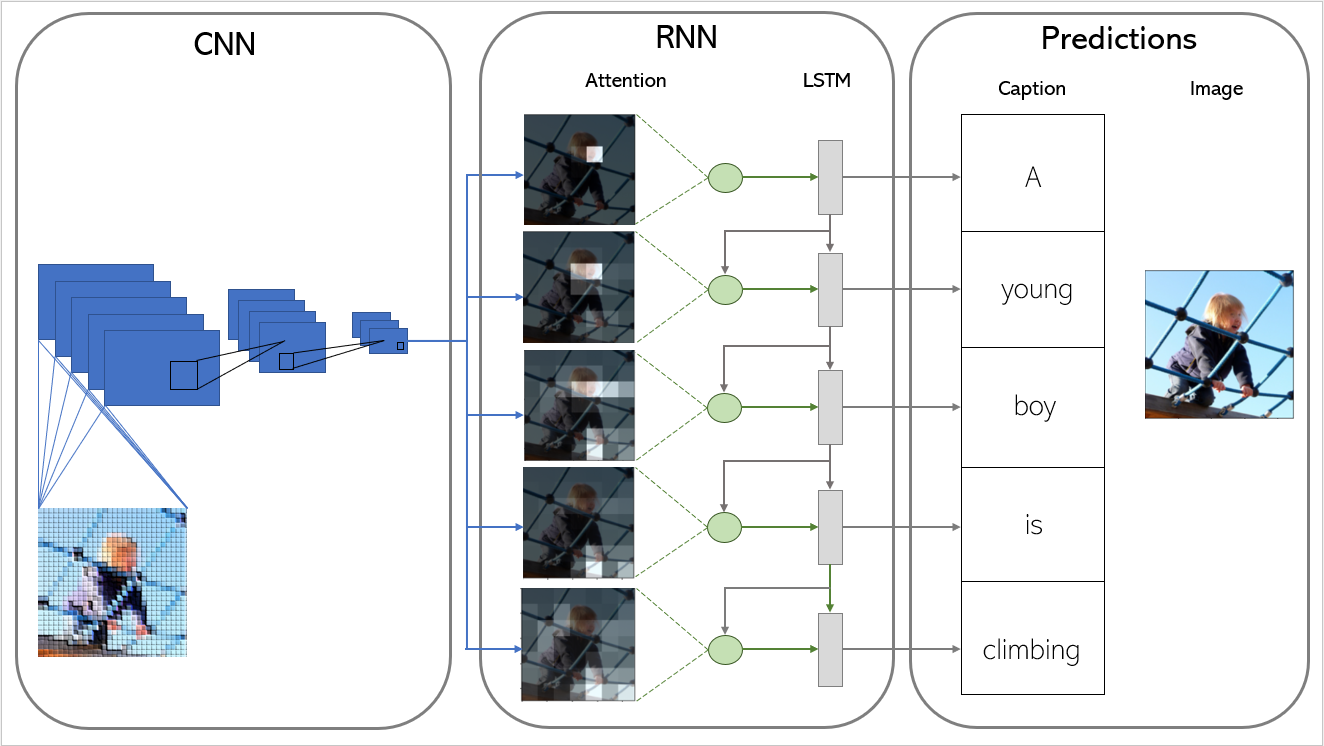

## Data Processing 

*Import the necessary libraries.*

In [1]:
#importing system 
import os

#importing torch 
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

#pretrained models for transfer learning
import torchvision.models

#supporting libraries
import pandas
import spacy
from PIL import Image
import numpy as np
import random
import math
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import itertools
from sklearn.preprocessing import OrdinalEncoder
import time
import copy
from datetime import datetime
from os import listdir
from os.path import isfile, join
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

!pip install tqdm
from tqdm import tqdm

from google.colab import drive

*Loading the Data*

The Dataset we have used for our project is the Flickr 8k Dataset from Kaggle [1]. The dataset includes 8000 total images and five different captions per image (40000). The dataset includes a variety of different object-based images. The content of the images include humans, animals, buildings etc., and are easily identifiable with a clear subject matter.

We loaded in the images and captions separately.
A folder containing all of the images in the dataset was mounted onto data_dir, and a large single text file containing all the corresponding captions was mounted onto data_dir2.

For ease of hypertuning, trained model states were saved onto a database which was loaded in using data_dir3.

In [19]:
#mount drive
drive.mount('/content/drive')

#set directories
data_dir = '/content/drive/My Drive/MIE1517_Project/Images/Images'
data_dir2 = '/content/drive/My Drive/MIE1517_Project/Images/captions.txt'
data_dir3 = '/content/drive/MyDrive/MIE1517_Project/Final_model'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Language Processing

*Defining the Vocabulary*

The team selected the language processing library SpaCy for reading and characterizing the caption dataset. This library was used to build and construct our vocabulary for the model consisting of english words only.

For our language model, we created a class that constructs the vocabulary based on a frequency threshold of the words in the training captions. We have selected a word-based vocabulary as we are reading captions from a highly curated dataset, and more importantly, are only trying to generate short, simple captions that consist of low-complexity grammatical structures.

We initialized the vocabulary with the padding, start-of-sentence, end-of-sentence, and unknown tokens. After which, we used the caption dataset to complete the vocabulary dictionaries (itos and stoi). 


In [27]:
#use spacy for tokenization
spacy_eng = spacy.load("en")

class Vocabulary:
    """creates a vocabulary class which includes string/index mappings based on the input corpus"""
    def __init__(self, freq_threshold):
        #define important tokens which will be needed to aid sentence generation in the LSTM model
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                  if word not in self.stoi.keys(): # add new words if not already in the dictionary
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
        return frequency

    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)       
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

*Creating a Dataframe to Map Images to Captions*

The annotation dataframe is read from data_dir2 and serves as the mapping between each image name and its five corresponding captions.  We have displayed the five captions for one image to better illustrate the complexity of captions that the model will be trained on and aims to generate.

In [28]:
#loading captions to a dataframe
annotation = pandas.read_csv(data_dir2)
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


*Create the Input Data*

A class is created to combine and numericalize the captions dataset according to the vocabulary class defined above.

The captions associated with each image are passed through the vocabulary class, which numericalizes them according to the vocabulary and starts and closes each caption with "SOS" and "EOS" respectively. These captions are then transformed into a tensor for input into the model.

Similarly, the image files are resized and converted into an RGB tensor input for training. 

In [29]:
class FlickrDataset(Dataset):
    """Create a class to combine and numericalize the captions dataset"""
    def __init__(self, root_dir=data_dir, df=annotation, freq_threshold=2, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = df
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print('Number of captions: ', len(self.captions.tolist()))
        fre = self.vocab.build_vocabulary(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]

        numericalized_caption += self.vocab.numericalize(caption)
              
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

*Padding*

This class intakes a batch of images and captions. It pads the captions to a similar length and concatenate the images together as one batched input into the model. Pad_sequence was imported from torchvision. It pads a list of variable length and stacks them.

In [30]:
class MyCollate:
    """Class to pad captions so that all samples in each batch are the same length"""
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_value)
        
        return img, targets

*Data Loader*

This puts the processed images and caption data into a train and a validation Data Loader.  The Data Loader contains the ability to change hyperparameters during the training phase such as the batch size, frequency threshold and the validation split ratio. 

In [31]:
def get_loader(root_dir=data_dir, root_dir2=data_dir2, transform=None, batch_size_train=32, batch_size_valid=25, num_workers=2, freq_threshold=2, shuffle=True, pin_memory=True, val_split=0.1):
    """Dataloader to create training and validation loaders"""

    #loading in the dataframe and determining the number of train samples given the val_split
    annotation = pandas.read_csv(data_dir2)
    n_imgs = annotation['image'].nunique()*5
    train_imgs = int(n_imgs*(1-val_split))

    #splitting the dataframe into a train and validation dataframe
    annotation_train = annotation.loc[0:train_imgs]
    annotation_val = annotation.loc[train_imgs+1:].reset_index()

    #create train and validation datasets
    dataset_train = FlickrDataset(root_dir=root_dir, freq_threshold=freq_threshold, df=annotation_train, transform=transform)
    dataset_val = FlickrDataset(root_dir=root_dir, freq_threshold=freq_threshold, df=annotation_val, transform=transform)
    pad_value = dataset_train.vocab.stoi["<PAD>"]

    #setting validation vocab to be the same as the train vocab
    dataset_val.vocab.itos = dataset_train.vocab.itos.copy()
    dataset_val.vocab.stoi = dataset_train.vocab.stoi.copy()
    
    #create train and validation loaders
    loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, num_workers=num_workers, shuffle=shuffle, pin_memory=pin_memory, collate_fn=MyCollate(pad_value))
    loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size_valid, num_workers=num_workers, shuffle=shuffle, pin_memory=pin_memory, collate_fn=MyCollate(pad_value))

    return loader_train, dataset_train, loader_val, dataset_val

### Testing Vocabulary Functions and Exploratory Data Analysis

*Visualize the Vocabulary and Prediction*

Here we have created a visualization segment to display the shape of the vocabulary and ensure that the padding, batching and dataloading functions work correctly.

We define a vocabulary with a frequency threshold of 2.

In [8]:
df = pandas.read_csv(data_dir2)
        
captions = df['caption']
images = df['image']

#Select vocabulary threshold
vocab = Vocabulary(2)

#build vocabulary by feeding in all captions from the dataset
fre = vocab.build_vocabulary(captions.tolist())

print('Number of captions: ', len(captions.tolist()))
print('Number of words in Vocabulary: ', fre.__len__())

Number of captions:  40455
Number of words in Vocabulary:  8507


We can visualize the shape of the vocabulary produced from the caption dataset.  For plotting the vocabulary is orded by descending frequency (most common words first).

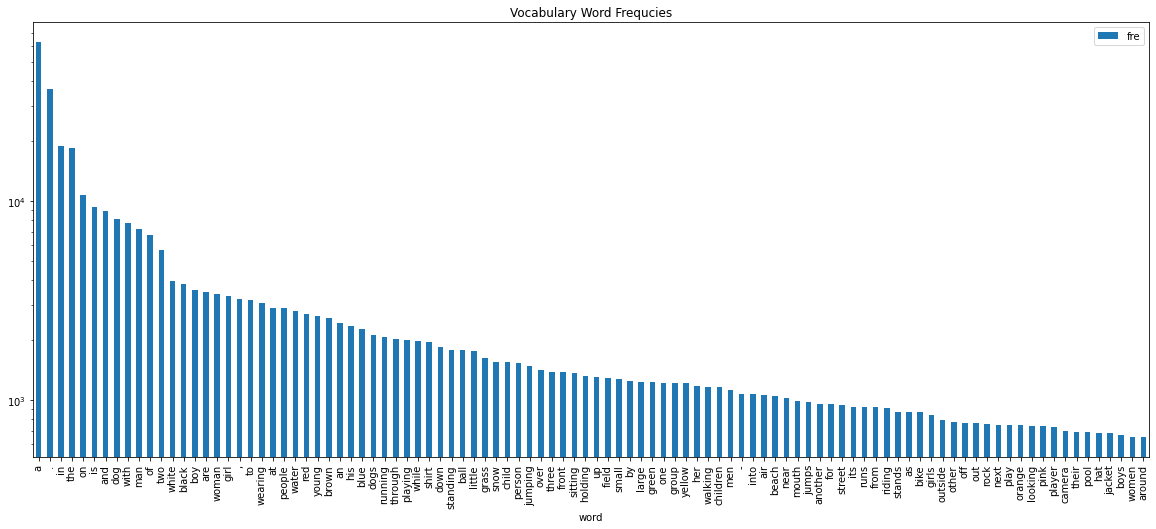

In [10]:
df_fre = pandas.DataFrame(fre.items(), columns = ['word', 'fre'])
df_fre = df_fre.sort_values(by=['fre'], ascending=False)
df_fre = df_fre.head(100)
#plot bar graph for most frequent 100 words
df_fre.plot.bar(x='word',y='fre', figsize=(20, 8), logy=True, title='Vocabulary Word Frequcies');

*Testing the data loader*

Here we try to load the captions and images via a data loader.

We also will print the shape of the output dataset to confirm that we are producing the correct tensor shape for images and captions when calling the loader.

In [9]:
transform = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])

print('Check sizes of train and validation datasets')
loader_train, dataset_train, loader_val, dataset_val = get_loader(root_dir=data_dir, root_dir2=data_dir2, transform=transform, batch_size_train=32, 
                                                                  num_workers=2, freq_threshold=2, shuffle=True, pin_memory=True, val_split=0.1)

print('\nShape of dataset_train')
x, y = dataset_train[math.floor(random.random() * len(dataset_train))]
print(x.shape, y.shape)

Check sizes of train and validation datasets
Number of captions:  36410
Number of captions:  4045

Shape of dataset_train
torch.Size([3, 300, 300]) torch.Size([13])


## Model Architectures 

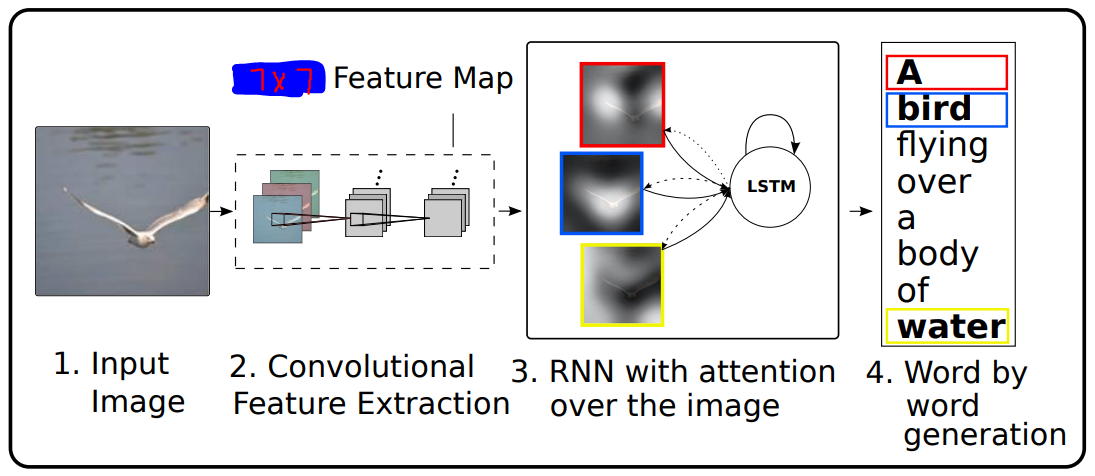

Source [7]

*Model Description*

For our project we are building a network for image captioning. There are different possibilities, but the model we selected for our design case is a connected CNN-RNN network. The research we have conducted indicates that this a robust set-up for end-end Sequence to Sequence problems like image captioning [2]. We are using a CNN network for image feature classification, which will be introduced into the RNN for caption generation. In the literature, this network set up is referred to an Injection Architecture. In our case, the word and image vectors are combined into a similar-sized embedding space and passed into the RNN, which results in an Injection Architecture type known as Par-Inject [3]. 

For the CNN we tested a variety of pre-trained CNN's and selected the one with the highest validation accuracy. The pre-trained model selected was the Inception model.

The RNN was model was built by the team and uses the LSTM module with attention.

The model architecture is as follows:

*  Pre-trained CNN Feature Extractor (get the feature map of size 2048X7X7)
*  Attention Mechanism (Context vector from last prediction and Feature map)
> *  Perform Soft attention on the feature map and context vector
> *  Output a new context vector. 
*  The generated context vectors then sent into the LSTM
*  LSTM predicts the next word via fully connected layers
*  New hidden layer from LSTM goes back into the Attention Mechanism to generate the next context vector for next word prediction.

Each time a new word is generated, the attention mechanism generates a new context vector by referring back to the image feature map and the last word's hidden state. This procedure does not lose the context of the images, as the images are referenced every time a new word is generated.

### CNN Model 

*CNN*

This is the CNN network. It uses the pre-trained Inception v3 model to classify the image features. During CNN selection, the Inception model had a training accuracy of 93.55%. 

The model takes the transformed Flickr images as inputs and outputs a feature classification vector in proportion with the embedding size.

We did not implement any fully connected layer to the pre-trained network. This is one of the requirements of the Attention Mechanism. Instead, we are accessing the CNN feature map directly. Within the EncoderCNN class, we first set all the parameters to no grad(meaning no weight update), and next, we slice the inception model at the 3rd last layer to get the features of the images in terms of a CNN filter shape 2048, 7, 7. These features are then permuted to reshape with batch size in the first dimension and then resized into shape (batch_size,49,2048).

In [11]:
class EncoderCNN(nn.Module):
    """Encoder using Inception v3 with Fully Connected Layers and Embedding Space"""
    def __init__(self):
        super(EncoderCNN, self).__init__()
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        for param in self.inception.parameters():
            param.requires_grad = False
       
        modules = list(self.inception.children())[:-3]
        self.inception = nn.Sequential(*modules)

    def forward(self, images):
        features = self.inception(images)                                 #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

### Attention Model

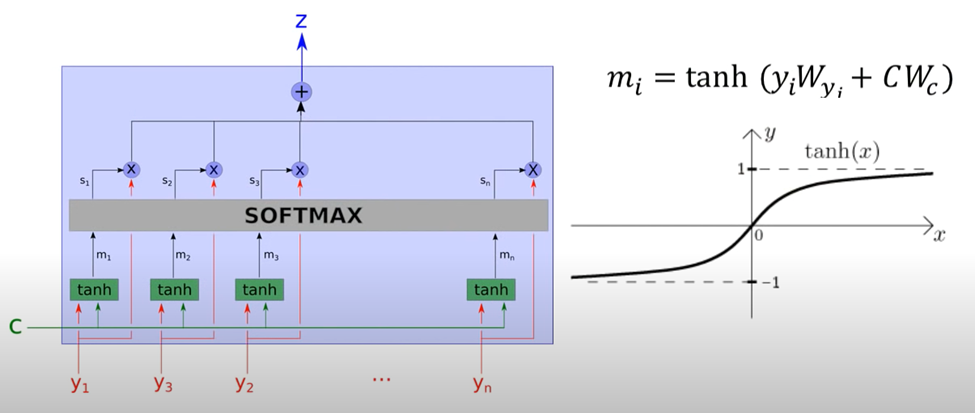



Source: [8]

The image above is a screen captured from the youtube video link above. This image describes the attention mechanisms which we have used. This attention mechanism was first introduced in Bahdanau Paper in 2014 [6]. In the images y represents the feature map which is extracted from the CNN in the last section, C is the context vector from the last predictions, Z is the output context vector that goes into LSTM.

Class Attention needs three inputs encoder dimensions, decoder dimensions, and attention dimensions. Encoder and decoder dimensions are required so the size of the features from CNN and the size of the last context vector can be normalized to the required attention dimensions. To achieve that, class attention uses fully connected layers on the input feature (feature map from CNN) and another fully connected layer on the context vector (output of the last prediction of the LSTM aka Decoder). Once the CNN features encoder and RNN features decoder are normalized they get multiplied and get normalized with sigmoid activation. 

The output of the sigmoid activation is then sent to a softmax to get the deterministic probability. This generated probability is then multiplied and summed with the feature map of the CNN. Performing these operations generates the new context vector which includes only the feature to which the LSTM should pay attention. Due to softmax, all the features which have low probability are simply put to zero, and features with the highest probability are given a large context value. 

In [12]:
class Attention(nn.Module):
    """Bahdanau Attention Soft"""
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attention_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
         
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha, attention_weights

### DecoderRNN Model

*LSTM*

We decided to use LSTM for the decoder part of our model. LSTM has several benefits. It can retain long-term information about the sentences which is required. Model gets a larger space by having cell state and hidden state to store learned parameters. 

As we decided to use attention for our project, the LSTM code was modified to incorporate an attention mechanism. The attention mechanism is not used on its own. Class DecoderRNN calls in the attention class to filter out the feature extracted from CNN. In simple words, attention is a filter that only allows features that are relevant for the specific word predictions. 

Class DecoderRNN requires six parameters embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim and drop_prob.

* embed_size: is the selected embedding space for the hidden state and cell state
* vocab_size: is the vocabulary size
* attention_dim: is the parameter that determines the size of the context vector (see attention class for more detail)
* encoder_dim and decoder_dim: these two parameters are required for attention class. These parameters help the feature map space and context vector space to be normalized to the same size to perform soft attentions.

embed_size, attention_dim. encoder_dim and decoder_dim are all hyperparameters that can be tuned to improve the model performance. 

In DecoderRNN init, all the layers are defined:

emebdding layer for LSTM defined
* self.embedding = nn.Embedding(vocab_size,embed_size)

Attention Mechanism initilized
* self.attention = Attention(encoder_dim,decoder_dim,attention_dim)

Hidden state and cell state fully connected layers defined
* self.init_h = nn.Linear(encoder_dim, decoder_dim)  
* self.init_c = nn.Linear(encoder_dim, decoder_dim)  

LSTM Initialized
* self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)

Fully connected layers defined for model classifications
* self.f_beta = nn.Linear(decoder_dim, encoder_dim)
* self.fcn = nn.Linear(decoder_dim,vocab_size)

Dropout to prevent overfitting
* self.drop = nn.Dropout(drop_prob)

In the forward DecoderRNN, the feature map and the image captions are inputted. 
The forward loop can take in the entire caption at once along with its image and predict the full sentence in one go. This is achieved by the attention loop in the function.
         
        for s in range(seq_length):
            alpha,context = self.attention(features, h) #features are from CNN, h is intializes random
            lstm_input = torch.cat((embeds[:, s], context), dim=1) #context vector gets embeds 
            h, c = self.lstm_cell(lstm_input, (h, c)) #hidden state and cell states update lstm layer   
            output = self.fcn(self.drop(h)) #fully connected layer with output size of vocab
            
            preds[:,s] = output #saving the predictions of every word in the sentence
            alphas[:,s] = alpha  #saving the alpha value for attention visualization
        
        return preds, alphas


This for loop takes the entire sentence and can either train on the caption or predict on the images. While training the seq_length comes from the actual caption length during predicting this is defined by the max_len of the caption which is inputted during the model evaluations. 

Once all the required parameters are initialized h, c, embeds, preds, and alphas this for loop goes over the sentence till the end of the sentence is reached or max_length of the sentence is achieved (during prediction). 

The Context vector is first calculated along with the alpha (alpha is only used for attention visualization). A reminder context vector is the filtered features from the CNN. A context vector is then concatenated with the embedding space which becomes the input to the first LSTM layer. Hidden state and cell state are trained next (during training)/ or hidden state and cells states are evaluated (during inferencing). Once hidden state and cells states are evaluated, the hidden state goes through the fully connected layer which outputs the probability space for all the classes in the vocabulary space. The output is stored in a tensor and alphas are stored into a tensor. The preds (tensor) are later used to generate the predictions by using vocab.itos. Alphas are used to visualize the attention over the images. 

The DecoderRNN class was built in part from the following resource [5]



In [13]:
class DecoderRNN(nn.Module):
    """Attention Decoder using LSTM network"""
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    def forward(self, features, captions):
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).cuda()
        alphas = torch.zeros(batch_size, seq_length,num_features).cuda()

        #loop to apply the attention mechanison and updating the LSTM hidden and cell state         
        for s in range(seq_length):
            alpha,context = self.attention(features, h) #features are from CNN, h is intializes random
            lstm_input = torch.cat((embeds[:, s], context), dim=1) #context vector gets embeds 
            h, c = self.lstm_cell(lstm_input, (h, c)) #hidden state and cell states update lstm layer   
            output = self.fcn(self.drop(h)) #fully connected layer with output size of vocab
            
            preds[:,s] = output #saving the predictions of every word in the sentence
            alphas[:,s] = alpha  #saving the alpha value for attention visualization
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=30,vocab=None):
        # Inference part.  Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).cuda()
        embeds = self.embedding(word)

        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            #store the alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

### CNN To RNN Model

*CNN-RNN*

This combines the CNN and RNN into one class and calls the models together. It is also where the sampling for the output predictions is handled.  

The CNN_RNN class was built in part from the following resource [4]

In [14]:
class EncoderDecoder(nn.Module):
    """Complete Encoder and Decoder Model"""
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

### Train Functions

*Training the Model*

For training the Model we used the full Flickr 8k dataset (40000 captions). 

CNN:
For the CNN, we extracted the Inception features. All the Inception model parameters were set to no gradiant. Extracting and training the features lead to high-ram issues and did not demonstrate a difference in image classification performance.

RNN:
For the RNN, teacher enforcing was used and the criterion selected for the loss was multi-class cross entropy.

Loading the Model:
We have created functionality to load a previously trained model. This allows us to the load the last model that was saved to the shared google drive. In this way, the training can be done across batched epochs, as opposed to a full-training of the model for all epochs at once. This provides more flexibility in the hyperparameter tuning and allows the team to train with the highest efficiency. 

Hyperparameters:
We evaluated a variety of vocabulary size, hidden space, embedding size, learning rate, and batch size values based on Image Captioning models found in our research.

*Image Display*

This function visualizes the images that we are using during training and testing. During data transform, the images were normalized via the mean and std. In this function first images are unnormalize with the same values to see the images clearly. This allowed the team to get a qualitative assessment of the training process without having to rely on numerical evaluations exclusively.

In [15]:
def show_image(img, title=None):
    """Imshow for Tensor."""   
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
      
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

*Arguments*

We built an argument class that centralized the hyperparameter selection. This helped during training because it allowed us to update the learning rate across different save-states and epochs.

In [17]:
class AttrDict(dict):
    """Define class to feed model parameters to training function"""
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self 

*Training Function*

This is the training code that was used to train the model.

In [34]:
def RNN_train_cuda(args, loadfile = True, filename = False):
    """CNN-RNN training function"""  
    # Hyperparameters loading from args
    embed_size = args.embed_space 
    hidden_size = args.hidden_size 
    num_layers = args.num_layers
    learning_rate = args.learn_rate 
    num_epochs = args.epochs
    print_every = args.print_every 
    batch_size = args.batch_size
    freq_threshold = args.freq_threshold
    attention_dim = args.attention_dim
    encoder_dim = args.encoder_dim
    decoder_dim = args.decoder_dim
    model_load_name = args.model_load_name
       
    # loading data
    transform = transforms.Compose([transforms.Resize((356, 356)), transforms.RandomCrop((299, 299)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    train_loader, dataset_train, val_loader, dataset_val = get_loader(root_dir=data_dir, root_dir2=data_dir2, transform=transform, batch_size_train=batch_size, 
                                                                      num_workers=2, freq_threshold=freq_threshold, shuffle=True, pin_memory=True, val_split=0.1)
   
    vocab_size = len(dataset_train.vocab)

    # intializing the model and loading the loss tracker dataframe
    state_data = pandas.read_csv("/content/drive/MyDrive/MIE1517_Project/loss_save/loss_dataframe.csv", index_col=0)
    model = EncoderDecoder(embed_size=embed_size,vocab_size = vocab_size,attention_dim=attention_dim,encoder_dim=encoder_dim,decoder_dim=decoder_dim)

    # if loadfile and filename are true then load parameters from a specific file
    # if loadfile is True and filename is False then load parameters from the best result
    if loadfile == True:
        if filename == True:
            model_save_name = model_load_name
        else:
            onlyfiles = [f for f in listdir(data_dir3) if isfile(join(data_dir3, f))]
            model_save_name = str(onlyfiles[-1])
        best_loss = float(model_save_name[-6:])
        print('Model file loading, file model', model_save_name)
        path = F"/content/drive/MyDrive/MIE1517_Project/Final_model/{model_save_name}" 
        state = torch.load(path)
        model.load_state_dict(state) # load model state
        print('Model loaded')
    else:
        best_loss = 10

    model.cuda()

    # initialize optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=dataset_train.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    itr = 0
    chencherry = SmoothingFunction()
    bleu1, bleu2, bleu3, bleu4 = [], [], [], []
    loss_list, loss_list_val = [], []

    for epoch in range(1,num_epochs+1):   
        avg_loss = 0
        Total_loss = 0

        for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False) :
            imgs = imgs.cuda()
            captions = captions.cuda()

            # Feed forward
            outputs,attentions = model(imgs, captions)

            # Calculate the batch loss.
            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            avg_loss +=loss
            Total_loss +=loss

            #increment iteration count
            itr += 1 

            if itr % print_every == 0:
                print("[Iter %d] The Loss is %f" % (itr+1, float(avg_loss/print_every)))
                avg_loss = 0

        model.eval()

        # compute bleu scores and append to each bleu score list
        with torch.no_grad():
            reference=[]
            dataiter = iter(train_loader)
            img,label = next(dataiter)
            for i in label[0]:
                reference.append(dataset_train.vocab.itos[int(i)])
            reference = [reference]
            features = model.encoder(img[0:1].cuda())
            caps,alphas = model.decoder.generate_caption(features,vocab=dataset_train.vocab)
            bleu_score1 = sentence_bleu(reference, caps, weights=(1, 0, 0, 0),smoothing_function=chencherry.method1)
            bleu_score2 = sentence_bleu(reference, caps, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1)
            bleu_score3 = sentence_bleu(reference, caps, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method1)
            bleu_score4 = sentence_bleu(reference, caps, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1)
            caption = ' '.join(caps)
            show_image(img[0],title=caption)
        bleu1.append(bleu_score1)
        bleu2.append(bleu_score2)
        bleu3.append(bleu_score3)
        bleu4.append(bleu_score4)   
              
        avg_loss = (Total_loss/idx).item()

        loss_val = 0
        
        torch.cuda.empty_cache()

        # calculate model validation loss
        for idx, (imgs, captions) in tqdm(enumerate(val_loader), total=len(val_loader), leave=False) :
            imgs = imgs.cuda()
            captions = captions.cuda()
            outputs, attentions = model(imgs, captions)
            targets = captions[:,1:]
            loss_val += criterion(outputs.view(-1, vocab_size), targets.reshape(-1)).item() 
            
        avg_loss_val = (loss_val/idx)
        print('Val loss ', avg_loss_val)

        model.train()

        torch.cuda.empty_cache()

        loss_list.append(avg_loss)
        loss_list_val.append(avg_loss_val)

        #save the latest model
        if avg_loss < best_loss:
            print('Saving File')
            best_loss = avg_loss
            avg_loss = "{:.4f}".format(avg_loss)
            model_save_name = 'cnn_rnn' + '_' + str(batch_size) + '_' + str(learning_rate) + '_' + str(epoch) + '_' +  str(datetime.now()) + '_' +  str(avg_loss)
            path = F"/content/drive/MyDrive/MIE1517_Project/model_save/{model_save_name}" 
            torch.save(model.state_dict(), path)
            print('File Saved')

    # save state parameters to tracking dataframe
    state_data1 = pandas.DataFrame(columns = ['train_loss', 'val_loss', 'blue_score1', 'blue_score2', 'blue_score3', 'blue_score4'])
    state_data1['train_loss'] = loss_list
    state_data1['val_loss'] = loss_list_val
    state_data1['blue_score1'] = bleu1
    state_data1['blue_score2'] = bleu2
    state_data1['blue_score3'] = bleu3
    state_data1['blue_score4'] = bleu4
    state_data = state_data.append(state_data1).reset_index(drop=True)
    state_data.to_csv("/content/drive/MyDrive/MIE1517_Project/loss_save/loss_dataframe.csv")

    return model, loss_list, loss_list_val, bleu1, bleu2, bleu3, bleu4

#### Training with 10% Validation

For the first 20 epochs we trained with a learning rate of 0.0003. After which, for epochs 20-30, we decreased the learning rate by 0.00001 for every three epochs.

Number of captions:  36410
Number of captions:  4045
Model file loading, file model cnn_rnn_256_6.2e-05_3_2021-12-04 23:52:14.856930_2.0504
Model loaded


  7%|▋         | 10/143 [00:31<05:33,  2.51s/it]

[Iter 11] The Loss is 2.028605


 14%|█▍        | 20/143 [01:00<05:17,  2.58s/it]

[Iter 21] The Loss is 1.992753


 21%|██        | 30/143 [01:30<04:56,  2.62s/it]

[Iter 31] The Loss is 2.011255


 28%|██▊       | 40/143 [01:59<04:28,  2.61s/it]

[Iter 41] The Loss is 2.003318


 35%|███▍      | 50/143 [02:28<03:56,  2.54s/it]

[Iter 51] The Loss is 1.990775


 42%|████▏     | 60/143 [02:57<03:31,  2.55s/it]

[Iter 61] The Loss is 2.007121


 49%|████▉     | 70/143 [03:26<03:07,  2.57s/it]

[Iter 71] The Loss is 2.003167


 56%|█████▌    | 80/143 [03:55<02:40,  2.55s/it]

[Iter 81] The Loss is 2.009700


 63%|██████▎   | 90/143 [04:25<02:18,  2.61s/it]

[Iter 91] The Loss is 2.032437


 70%|██████▉   | 100/143 [04:54<01:50,  2.58s/it]

[Iter 101] The Loss is 2.034044


 77%|███████▋  | 110/143 [05:22<01:20,  2.45s/it]

[Iter 111] The Loss is 2.020731


 84%|████████▍ | 120/143 [05:52<01:00,  2.61s/it]

[Iter 121] The Loss is 2.019083


 91%|█████████ | 130/143 [06:21<00:33,  2.56s/it]

[Iter 131] The Loss is 2.030263


 98%|█████████▊| 140/143 [06:49<00:07,  2.51s/it]

[Iter 141] The Loss is 2.027872


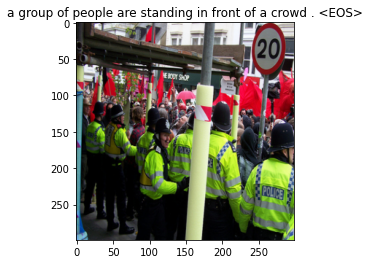

Val loss  1.9094317647981347
Saving File
File Saved


  5%|▍         | 7/143 [00:25<08:04,  3.56s/it]

[Iter 151] The Loss is 1.389122


 12%|█▏        | 17/143 [00:55<07:03,  3.36s/it]

[Iter 161] The Loss is 2.014126


 19%|█▉        | 27/143 [01:26<06:37,  3.43s/it]

[Iter 171] The Loss is 1.981569


 26%|██▌       | 37/143 [01:56<05:59,  3.39s/it]

[Iter 181] The Loss is 1.997801


 33%|███▎      | 47/143 [02:26<05:30,  3.44s/it]

[Iter 191] The Loss is 2.005149


 40%|███▉      | 57/143 [02:57<04:54,  3.43s/it]

[Iter 201] The Loss is 1.982824


 47%|████▋     | 67/143 [03:28<04:18,  3.40s/it]

[Iter 211] The Loss is 2.012602


 54%|█████▍    | 77/143 [03:58<03:45,  3.41s/it]

[Iter 221] The Loss is 1.985291


 61%|██████    | 87/143 [04:29<03:14,  3.48s/it]

[Iter 231] The Loss is 1.993259


 68%|██████▊   | 97/143 [04:59<02:35,  3.38s/it]

[Iter 241] The Loss is 1.985432


 75%|███████▍  | 107/143 [05:30<02:04,  3.47s/it]

[Iter 251] The Loss is 1.987963


 82%|████████▏ | 117/143 [06:00<01:29,  3.43s/it]

[Iter 261] The Loss is 2.018592


 89%|████████▉ | 127/143 [06:31<00:55,  3.46s/it]

[Iter 271] The Loss is 2.004254


 96%|█████████▌| 137/143 [07:01<00:20,  3.41s/it]

[Iter 281] The Loss is 1.990477


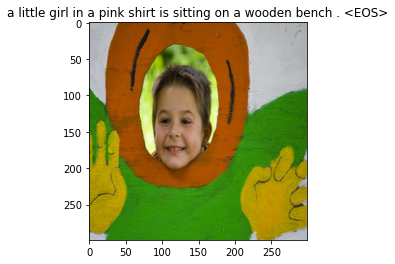

Val loss  1.9448839337189006
Saving File
File Saved


  3%|▎         | 4/143 [00:14<07:13,  3.12s/it]

[Iter 291] The Loss is 0.804456


 10%|▉         | 14/143 [00:45<05:46,  2.69s/it]

[Iter 301] The Loss is 1.994687


 17%|█▋        | 24/143 [01:16<05:15,  2.65s/it]

[Iter 311] The Loss is 1.983499


 24%|██▍       | 34/143 [01:46<04:48,  2.64s/it]

[Iter 321] The Loss is 1.979390


 31%|███       | 44/143 [02:17<04:36,  2.80s/it]

[Iter 331] The Loss is 1.985550


 38%|███▊      | 54/143 [02:48<04:00,  2.70s/it]

[Iter 341] The Loss is 1.999303


 45%|████▍     | 64/143 [03:18<03:31,  2.68s/it]

[Iter 351] The Loss is 1.983898


 52%|█████▏    | 74/143 [03:49<03:05,  2.68s/it]

[Iter 361] The Loss is 1.979649


 59%|█████▊    | 84/143 [04:20<02:38,  2.69s/it]

[Iter 371] The Loss is 1.986640


 66%|██████▌   | 94/143 [04:50<02:09,  2.64s/it]

[Iter 381] The Loss is 1.992070


 73%|███████▎  | 104/143 [05:21<01:44,  2.68s/it]

[Iter 391] The Loss is 2.008842


 80%|███████▉  | 114/143 [05:51<01:17,  2.67s/it]

[Iter 401] The Loss is 1.998304


 87%|████████▋ | 124/143 [06:21<00:51,  2.70s/it]

[Iter 411] The Loss is 1.994444


 94%|█████████▎| 134/143 [06:52<00:24,  2.72s/it]

[Iter 421] The Loss is 2.016874


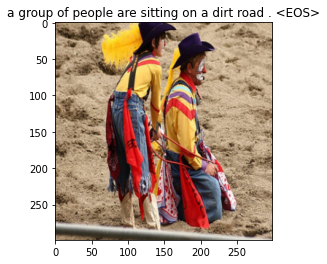

Val loss  1.9877353432756033
Saving File
File Saved


In [36]:
args = AttrDict()
args_dict = {
    "embed_space": 300, 
    'hidden_size': 256, 
    'num_layers': 2, 
    'learn_rate':0.00006, 
    "batch_size":256,
    "epochs": 3,   
    "freq_threshold": 2, 
    "seed": 42,
    "attention_dim": 256, 
    "encoder_dim": 2048, 
    "decoder_dim": 512, 
    'print_every': 10,
    'model_load_name':'last_saved_file',
}
args.update(args_dict)

model, loss_list, loss_list_val, bleu1, bleu2, bleu3, bleu4 = RNN_train_cuda(args, loadfile=True)

###Loading Final Model

This is the file for the fully trained model.

In [ ]:
model_final = EncoderDecoder(embed_size=300,vocab_size = 5169,attention_dim=256,encoder_dim=2048,decoder_dim=512)
path = F"/content/drive/MyDrive/MIE1517_Project/Final_model/cnn_rnn_256_6.2e-05_3_2021-12-04 23:52:14.856930_2.0504" 
state = torch.load(path)
model_final.load_state_dict(state)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

<All keys matched successfully>

###Plotting Loss

In [ ]:
loss_df=pandas.read_csv("/content/drive/MyDrive/MIE1517_Project/loss_save/loss_dataframe.csv")

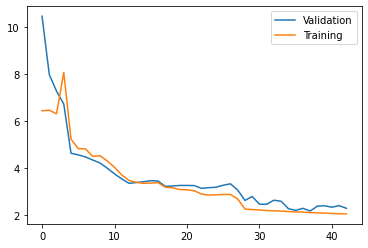

In [ ]:
plt.plot(loss_df['val_loss'],label='Validation')
plt.plot(loss_df['train_loss'], label='Training')
plt.legend()

## Example on Testing Data

###Loading Test Images and Captions Directories

Each one of the team members collected approximately 10 test images with their corresponding captions. The images and captions were then organized to match the folder layout of the train folder. 

In [ ]:
test_dir = '/content/drive/MyDrive/MIE1517_Project/Test_images/Images'
test_dir2 = '/content/drive/MyDrive/MIE1517_Project/Test_images/captions.csv'

###Test Loader

In [ ]:
def get_test_loader(root_dir=test_dir, root_dir2=test_dir2, transform=None, batch_size=1, num_workers=2, freq_threshold=2, shuffle=False, pin_memory=True):
  test_annotation = pandas.read_csv(test_dir2)
  dataset_test = FlickrDataset(root_dir=root_dir, freq_threshold=freq_threshold, df=test_annotation, transform=transform)
  pad_value = dataset_train.vocab.stoi["<PAD>"]
  dataset_test.vocab.itos=dataset_train.vocab.itos.copy()

  loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, pin_memory=pin_memory, collate_fn=MyCollate(pad_value))

  return loader_test, dataset_test

In [ ]:
# create test dataframe
test_annotation=pandas.read_csv(test_dir2)

###Plot results

In [ ]:
def plot_attention(img, result, attention_plot):
    """Plot the image as well as an overlay of the attention"""
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img
    fig = plt.figure(figsize=(18, 5))
    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(8,8)
        
        ax = fig.add_subplot(1, len_result, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        
    plt.tight_layout()
    plt.show()

In [ ]:
#get train, validation and test loaders
transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

loader_train, dataset_train, loader_val, dataset_val = get_loader(root_dir=data_dir, root_dir2=data_dir2, transform=transform, batch_size_train=32, num_workers=2, freq_threshold=2, shuffle=True, pin_memory=True, val_split=0.1)

test_loader, dataset_test = get_test_loader(root_dir=test_dir, root_dir2=test_dir2, transform=transform,shuffle=False, pin_memory=True)

Number of captions:  36410
Number of captions:  4045
Number of captions:  36


###Testing function

In [ ]:
def test_prediction(model, dataset):
    """output caption predictions and attention plots for test images"""
    bleu1, bleu2, bleu3, bleu4 = [], [], [], []

    model=model.cuda()

    for idx, (imgs, captions) in enumerate(test_loader):
        reference=[]
        imgs1 = imgs
        imgs = imgs.cuda()

        model.eval()
        reference = [test_annotation.loc[idx]['caption'].split()]
        features = model.encoder(imgs[0:1])
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset_train.vocab)

        #bleu score calculation
        chencherry = SmoothingFunction()
        bleu_score1 = sentence_bleu(reference, caps, weights=(1, 0, 0, 0),smoothing_function=chencherry.method1)
        bleu_score2 = sentence_bleu(reference, caps, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1)
        bleu_score3 = sentence_bleu(reference, caps, weights=(0.33, 0.33, 0.33, 0),smoothing_function=chencherry.method1)
        bleu_score4 = sentence_bleu(reference, caps, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1)

        caption = ' '.join(caps)
        bleu1.append(bleu_score1) #1_gram score
        bleu2.append(bleu_score2) #2_gram score
        bleu3.append(bleu_score3) #3_gram score
        bleu4.append(bleu_score4) #4_gram score

        print("\nPREDICTED OUTPUT: ", caption)
        print("ORIGINAL CAPTION: ", test_annotation.loc[idx]['caption'])

        #ploting images and attention overlay
        show_image(imgs1.squeeze(0).permute(0,1,2), title=None)
        plot_attention(imgs1.squeeze(0).permute(0,1,2).detach().clone(), caps, alphas)
    
    #recording the results to a dataframe
    state_data1 = pandas.DataFrame(columns = ['blue_score1', 'blue_score2', 'blue_score3', 'blue_score4'])
    state_data1['blue_score1'] = bleu1
    state_data1['blue_score2'] = bleu2
    state_data1['blue_score3'] = bleu3
    state_data1['blue_score4'] = bleu4

    return(state_data1)

In [ ]:
# output test predictions as well as bleu scores
blue_score=test_prediction(model_final, dataset_test)
print(blue_score)

Output hidden; open in https://colab.research.google.com to view.

##Qualitative and Quantitative Results

*Qualitative Results*

What we see from the above predictions on our test data is that some captions are predicted very well while other captions show good sentence structure but do not accurately caption the images.  

We can see some good examples of image captioning looking at an image of a skier skiing down a hill.  While the caption does not completely match, the context is perfect.  The three men playing soccer were also predicted well however the predicted output has many different words and the sentence is composed differently.  This shows the model predicting a fairly accurate output but would show a higher loss than expected situation.

If we look at the women standing in front of a bench in the park we see that predicted caption does not predict the correct context and the model is predicting a man with a red shirt and a rock.  This example illustrates some of the bias found while training the model as incorrect predictions can commonly be found to predict men with red shirts. 

Items which are not appearing often in the training can show high errors as well as the front of a vehicle was predicted as a bicycle.  In some other cases we see that a black dog is correctly predicted however the action it is doing was miscaptioned. 

*Quantitative Results*

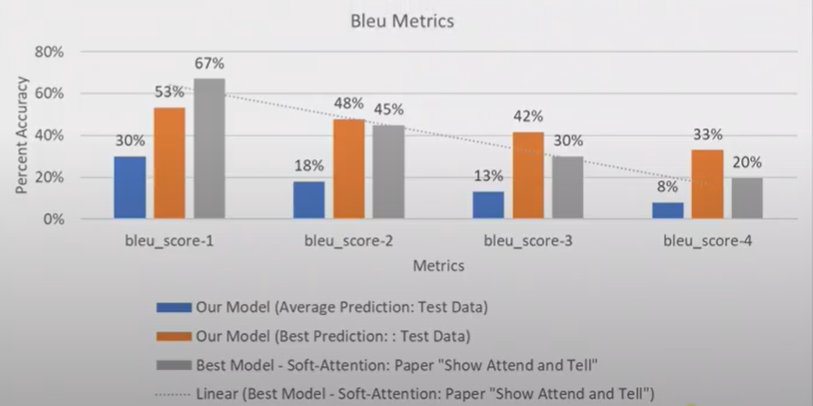


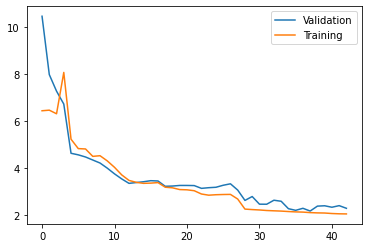

To measure the performance of our model quantitatively, we tracked the training and validation loss. As it can be seen, from the shape of the loss curve the model has flattened achieving a loss of 2.5. Neither underfitting nor overfitting has occurred during training, as the validation curve has not started to diverge. This indicated to us that more training can be done. However, due to time constraints and computation power limitations, we decided to stop the training. The results obtained from this training are very reasonable. The sentence structure is good, and object detection in the pictures is very good. However, due to the dataset being unbalanced as explained in qualitative results, the model tends to predict a sentence with "A Man", "Red Shirt", and "shirt" more often than other words in the vocabulary. This can be resolved by balancing the dataset of captions.

We have also implemented a Bleu-score system, which evaluates the likeness of the target and predicted captions on a multi-gram scale. Our quantitative results are summarized in the graph above. The blue bar shows our average bleu score for our test dataset. Our model has achieved an average bleu-score ngram of 30%, 18%, 13%, and 8%. However, our best prediction achieved a uni-gram blue score of 53%, 48%, 42%, and 33%.  According to the research, the best model has achieved ngram bleu-score of 67%, 45%, 30%, and 20%, for ngram 1,2,3, and 4 respectively.  

As it can be seen our model performed quite well on some images compared to others. However, as this is a text generation task, bleu score does not consider the semantic meaning of the sentence. Some generated caption will describe the image perfectly but will result in a low bleu score as the generated caption won’t match the original captions word to word.

##Summary of Background

Our model can be compared with the paper Show Attend and Tell [7]. This paper was published in 2016 and co-authored by a famous professor Yoshua Bengio. This model is unlike other image captioning models because it integrates visual attention into the process of generating the word descriptions from visual features.

In the reference paper, the model architecture is as follows:

1.   Pre-trained CNN Feature Extractor (get the feature map)
2.   Attention Mechanism (Context vector from last prediction and Feature map)
3.   Perform Soft and hard attention on the vectors in step 2
4.   Outputs new context vector. Soft attention outputs are deterministic, where hard attentions outputs are sampled probabilistically from the attention feature map.
5.   The generated context vectors (either hard or soft) are then sent into the LSTM Hidden State
6.   LSTM takes the Attention context vector, output from the last prediction, embedding space, and outputs the next predictions from the vocabulary.


The paper used both hard and soft, whereas we only went with Soft Attention. Soft Attention is easier to train and can fully depend on backpropagation to train. For hard attention, one must incorporate Markov Decision process to sample the feature space probabilistically.  

In the paper authors used VGG architecture to extract the feature map, in our model we decided to use the Inception model to perform the feature extraction. The inception model performed quite well.

**Comparison:**

*   Paper's model used VGG 512x14x14 feature map, our model used Inception with feature map of 2048x7x7
*   The paper utilized several attention mechanisms: soft, hard, and doubly stochastic attention. Due to time constraints and knowledge limitations, we only implemented soft attention which was first introduced by Bahdanau in 2014 [6].
*   Like Show, Attend, and Tell we used visual attention to showcase the context vector overlayed on the image which highlights the area of the picture to which the model is paying attention to. The output of the visual attention can be seen in the model testing section.

##Discussion

Overall, group 10 can confidently say that we are satisfied with our results, and believe the model has performed above expectations. Quantitatively we have developed a CNN-RNN image-captioning model that has achieved comparable bleu-score accuracies with many of the models reported in the literature. Furthermore, our loss curve shows a good asymptotic shape without indicition of overfitting. Qualitatively, the sentences are impressive. Grammaticaly, they are cohesive, and frequently describe the subject matter in part, if not fully. These generated sentences are varied and comprehensive, even for instances with low accuracy. 

It is surprising that the model has developed such a strong competency of the English language, in particular, it almost perfectly identifies the primary subject of each image. The accuracy for identifying the verb or action of the image is less, but interestingly, it is very profficient in correctly labeling the object that the subject is acting upon (i.e. skateboards, bicycles, basket ball etc.). 

We believe with further data this model may be capable of even better results.

## Bibliography

[1] adityajn105, "Flickr 8k Dataset: Flickr8k Dataset for image captioning." Kaggle, 2019. [Online]. Available:
https://www.kaggle.com/adityajn105/flickr8k/activity [Accessed on: 2021-11-22.]

[2] A. Chowdhry, "IMAGE CAPTION GENERATOR
CNN-LSTM Architecture And Image Captioning." Medium: Clairvoyant Blog, June 30, 2021. [Online]. Available:
https://blog.clairvoyantsoft.com/image-caption-generator-535b8e9a66ac [Accessed on: 2021-11-12]

[3] A. Roy, "A Guide to Image Captioning
How Deep Learning helps in captioning." Medium: Towards Data Science, December 9, 2020. [Online]. Available:
https://towardsdatascience.com/a-guide-to-image-captioning-e9fd5517f350 [Accessed on: 2021-11-22]

[4] aladdinpersson, "Machine-Learning-Collection." GitHub, Inc. January, 30, 2021. [Online]. Available: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/image_captioning/model.py [Accessed on: 2021-11-23]

[5] A. Bashyal, "Image Captioning With Attention - Pytorch". Kaggle. 2011. [Online]. Available: https://www.kaggle.com/mdteach/image-captioning-with-attention-pytorch/notebook [Accessed on: 2021-12-12]

[6] D. Bahdanau, K. Cho, Y. Bengio, "Neural Machine Translation". The International Conference on Learning Representations. 2015. [Online]. Available: https://arxiv.org/pdf/1409.0473.pdf [Accessed on: 2021-12-12]

[7] K. Wu, J.L. Bam, R. Kiros, et al, "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.Proceedings of the 32nd International Conference on Machine Learning, April 19, 2016. [Online]. Available: https://arxiv.org/pdf/1502.03044v3.pdf [Accessed on: 2021-12-12]

[8] CodeEmporium, "Attention in Neural Networks". YouTube, March 2, 2021. [Online]. Available: https://www.youtube.com/watch?v=W2rWgXJBZhU [Accessed on: 2021-12-16]

#Convert to HTML

In [1]:
%%shell
jupyter nbconvert --to html /content/MIE1517_Final_Project_Group_10.ipynb

[NbConvertApp] Converting notebook /content/MIE1517_Final_Project_Group_10.ipynb to html
[NbConvertApp] Writing 8295746 bytes to /content/MIE1517_Final_Project_Group_10.html
